In [2]:
import pandas as pd 
import numpy as np
import math
import itertools
from itertools import compress
import geopandas as gpd
import pickle
import xgboost as xgb
import polars
import os
from glob import glob
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from time import time
import math

from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
import polars
import warnings
warnings.filterwarnings("ignore")
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, make_scorer, f1_score, roc_auc_score


import sys
import os

sys.path.append('scripts')

In [1]:
kdprov = '12'

In [3]:
# Parameters
kdprov = 12


In [4]:
def akurasi_kelas_generatif(y_true, y_pred):
    # Calculate accuracy specifically for class 3
    class_3_mask = (y_true == 3)
    if np.any(class_3_mask):  # Check if class 3 is present in the true labels
        return accuracy_score(y_true[class_3_mask], y_pred[class_3_mask])
    else:
        return 0.0  # Return 0 if class 3 is not present in the true labels

def akurasi_fase_padi(y_true, y_pred):
    # Calculate accuracy specifically for classes 1, 2, 3, and 4
    class_1234_mask = (y_true >= 1) & (y_true <= 4)
    if np.any(class_1234_mask):  # Check if classes 1,2,3,4 are present in the true labels
        return accuracy_score(y_true[class_1234_mask], y_pred[class_1234_mask])
    else:
        return 0.0  # Return 0 if none of the classes 0-3 are present in the true labels

In [5]:
with open(f'/data/ksa/04_Data_Preprocessing/training-test/{kdprov}/fulldataset_VH.pkl', 'rb') as file:
    dt_full=pickle.load(file).to_pandas()

In [6]:
with open(f'/data/ksa/05_Modelling/model/xgboost{kdprov}_v2.pkl', 'rb') as file:
    xg_dt=pickle.load(file)

In [7]:
cluster=np.sort(dt_full.cluster_data.unique())

In [8]:
dict_predict={}
for cl in cluster:
    print('Predicting for cluster:',cl)
    start_time = time()
    dt_cl=dt_full.query('cluster_data==@cl')
    y = dt_cl.observation
    X = dt_cl.loc[:,'VH_30':'VH_0']
    X['nth'] = dt_cl.loc[:,'nth']
    X['nth'] = X.nth.astype('category')
    model=xg_dt[cl]['model']
    dtest = xgb.DMatrix(X, enable_categorical=True)
    y_pred_prob=model.predict(dtest)
    y_pred=y_pred_prob.argmax(axis=1)
    dt_pred=dt_cl[['idpoint', 'idsubsegment', 'idsegment','periode', 'observation','idkabkota', 'cluster_data']]
    dt_pred['prediction']=y_pred
    score={}
    score['accuracy']=accuracy_score(y, y_pred)
    score['f1_macro']=f1_score(y, y_pred, average='macro')
    score['f1_micro']=f1_score(y, y_pred, average='micro')
    score['auc']=roc_auc_score(y,y_pred_prob, multi_class='ovr')
    score['acc_generative']=akurasi_kelas_generatif(y, y_pred)
    score['acc_fase_padi']=akurasi_fase_padi(y, y_pred)
    cm = confusion_matrix(y, y_pred)
    relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    score['relative_acc']=relative_acc
    print(score)
    print(cm)
    end_time = time()
    elapsed_time = end_time - start_time
    print('Finish with processed time:',elapsed_time)
    dict_predict[cl]={'data_prediction':dt_pred,
                        'score':score,
                    'time':elapsed_time}

Predicting for cluster: 0
{'accuracy': 0.5979293577362058, 'f1_macro': np.float64(0.5631120873554859), 'f1_micro': np.float64(0.5979293577362058), 'auc': np.float64(0.8245293055425842), 'acc_generative': 0.5675791118635239, 'acc_fase_padi': 0.5483146729522687, 'relative_acc': np.float64(97.95000628882534)}
[[ 69008   2707    728   1274  16083  19896  38979]
 [  2290 109385  16916   2869   1074  18387  43554]
 [   360  20034  67924  17978    750    817  30287]
 [   626   1924  18088 108961  16780   1597  43999]
 [  9190    653    466  18625  85926   4115  35225]
 [ 14776  23592   1287   1113   5819  67117  35996]
 [ 30439  23034  13752  22190  20338  16739 377033]]
Finish with processed time: 21.755699396133423
Predicting for cluster: 1
{'accuracy': 0.5187874690105927, 'f1_macro': np.float64(0.4820617496233928), 'f1_micro': np.float64(0.5187874690105927), 'auc': np.float64(0.782348701327533), 'acc_generative': 0.5424946846208363, 'acc_fase_padi': 0.47235113630454, 'relative_acc': np.flo

{'accuracy': 0.5723591812341252, 'f1_macro': np.float64(0.5492638910609448), 'f1_micro': np.float64(0.5723591812341252), 'auc': np.float64(0.8776731980508987), 'acc_generative': 0.6210418021640158, 'acc_fase_padi': 0.603537347869736, 'relative_acc': np.float64(98.4717639667209)}
[[221892  14075   6680   6968  36190  43414  92881]
 [ 11329 226383  40776   3923   2057  35754  56828]
 [  3564  44032 158620  40011   1108   1018  39647]
 [  4180   3486  39676 262592  53837    412  58642]
 [ 31680    784    755  35766 209081   6570  46914]
 [ 52676  37026   4086   2876   7621 123493  39322]
 [  5163   3270   3997   4663   3979   2579  42949]]
Finish with processed time: 22.069522619247437
Predicting for cluster: 2


{'accuracy': 0.47043197329853015, 'f1_macro': np.float64(0.4477812471521461), 'f1_micro': np.float64(0.47043197329853015), 'auc': np.float64(0.7804546222021047), 'acc_generative': 0.5049939569736525, 'acc_fase_padi': 0.4409366477051352, 'relative_acc': np.float64(96.14767507707796)}
[[ 68550   6435   1499   5325   9000   5091  97825]
 [  2004  76445  10888   2677   6820   5785  67006]
 [  2217  15813  45761  19684    599    198  42778]
 [  3163   1477  14173 104458  15784    471  67324]
 [  8044   1691    432  14796  56263   2512  52387]
 [  5715  12859    467   2311  17748  14892  44708]
 [ 17664   7343   4245  10716   9221   1892 183319]]
Finish with processed time: 14.033454895019531
Predicting for cluster: 3


{'accuracy': 0.3399548592378918, 'f1_macro': np.float64(0.3266380952779916), 'f1_micro': np.float64(0.3399548592378918), 'auc': np.float64(0.7226394256484229), 'acc_generative': 0.0997864225781846, 'acc_fase_padi': 0.29802602830816, 'relative_acc': np.float64(87.08167740167193)}
[[158906   9948  19686   3152  33903  52502  55578]
 [ 34542  78753  72637   2382  28781  67770  71810]
 [ 25869  23468 141527   7817  17605  18655  55159]
 [ 34879   4914 103089  39246  99216  22789  89167]
 [ 33377   4488  21451   5476 132639  28289  50080]
 [ 19742  13017  10103    803  17692  58973  21445]
 [ 83224  15819  84890   7798  66818  58918 161883]]
Finish with processed time: 25.63498306274414
Predicting for cluster: 4


{'accuracy': 0.34497014663970577, 'f1_macro': np.float64(0.2995413926820517), 'f1_micro': np.float64(0.34497014663970577), 'auc': np.float64(0.6917066739961465), 'acc_generative': 0.24924636550994264, 'acc_fase_padi': 0.27879840238288656, 'relative_acc': np.float64(84.15067672904405)}
[[ 55945  22767  73665  13949   9445 133731 116898]
 [  6403  98004 101654   8086   5568 131368  84492]
 [  2626  21666 152611  25895   2545  36637  57770]
 [  4351   7782 119585 111868  31551  85547  88141]
 [  9637   6838  32268  23376  49358 110004  61569]
 [  6773  16226  16174   4222   5979  92827  34424]
 [ 25221  34624 184824  33105  16117 243520 522714]]
Finish with processed time: 58.49814319610596
Predicting for cluster: 5


{'accuracy': 0.38935701833636605, 'f1_macro': np.float64(0.35257640711532773), 'f1_micro': np.float64(0.38935701833636605), 'auc': np.float64(0.7308849932195765), 'acc_generative': 0.21192504804612428, 'acc_fase_padi': 0.29451465290624085, 'relative_acc': np.float64(81.59667137086963)}
[[100282   9008   1404   3084  20133  27021  30543]
 [ 30195 100592  11970   3081  35722  59742  54373]
 [ 28894  38921  37269  13848  35658  27982  40878]
 [ 32449  12542  19157  66163  98594  28150  55145]
 [ 22260   4456   1448  14171  98472  22880  32088]
 [ 15469  12083    810   1419  20990  55840  19989]
 [ 89602  29440   6511  11219  99754  76632 306342]]
Finish with processed time: 53.53613805770874


In [9]:
pivot_kabkota=[]
cm_prediction={}
df_for_estimation=[]
for cl in cluster:
    print('Running for cluster:',cl)
    df_pred=dict_predict[cl]['data_prediction']
    df_pred_dom=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['prediction'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_obs=df_pred.groupby(['idsubsegment', 'idkabkota','periode'])['observation'].agg(lambda x: x.mode()[0]).reset_index()
    df_pred_dom_obs=df_pred_dom.merge(df_pred_obs).rename(columns={'prediction':'dom_pred'})
    df_pred['idpoint_loc']=df_pred.idpoint.apply(lambda y:y.split('#')[1])
    df_pred_center=df_pred.query('idpoint_loc=="13"')[['idsubsegment', 'idkabkota','periode','prediction']]
    df_pred_center_obs=df_pred_center.merge(df_pred_obs).rename(columns={'prediction':'center_pred'})
    df_pred_subsegment=df_pred_center_obs.merge(df_pred_dom_obs)
    df_for_estimation.append(df_pred_subsegment)
    for idkab in df_pred.idkabkota.unique():
        #print('Get Metrics for Each Point Prediction')
        score={}
        score['idkabkota']=[idkab]
        y=df_pred.query('idkabkota==@idkab')['observation']
        y_pred=df_pred.query('idkabkota==@idkab')['prediction']
        score['accuracy_titik']=[accuracy_score(y, y_pred)]
        score['f1_macro_titik']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_titik']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_titik']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_titik']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_titik']=[relative_acc]
        cm_titik=cm
        
        y=df_pred_dom_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_dom_obs.query('idkabkota==@idkab')['dom_pred']
        
        #print('Get Metrics for Dominant Prediction')
        score['accuracy_dom']=[accuracy_score(y, y_pred)]
        score['f1_macro_dom']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_dom']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_dom']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_dom']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_dom']=[relative_acc]
        cm_dom=cm
        
        #print('Get Metrics for Center Point Prediction')
        y=df_pred_center_obs.query('idkabkota==@idkab')['observation']
        y_pred=df_pred_center_obs.query('idkabkota==@idkab')['center_pred']
        score['accuracy_center']=[accuracy_score(y, y_pred)]
        score['f1_macro_center']=[f1_score(y, y_pred, average='macro')]
        score['f1_micro_center']=[f1_score(y, y_pred, average='micro')]
        #score['auc']=[roc_auc_score(y,y_pred_prob, multi_class='ovr')]
        score['acc_generative_center']=[akurasi_kelas_generatif(y, y_pred)]
        score['acc_fase_padi_center']=[akurasi_fase_padi(y, y_pred)]
        cm = confusion_matrix(y, y_pred)
        relative_acc = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
        score['relative_acc_center']=[relative_acc]
        cm_center=cm
        cm_prediction[idkab]={'point':cm_titik,'dominant':cm_dom,'center':cm_center}
        pivotal_df=pd.DataFrame(score)
        pivot_kabkota.append(pivotal_df)
        #df_for_estimation.append()
pivot_kabkota=pd.concat(pivot_kabkota)
df_for_estimation=pd.concat(df_for_estimation)

Running for cluster: 0
Running for cluster: 1
Running for cluster: 2
Running for cluster: 3
Running for cluster: 4
Running for cluster: 5
Running for cluster: 6
Running for cluster: 7


Running for cluster: 2


Running for cluster: 3


Running for cluster: 4


Running for cluster: 5


In [11]:
cm=cm_prediction['1201']['dominant']
cm_percentage_by_row = cm.astype('float') / cm.sum(axis=1, keepdims=True) * 100
np.set_printoptions(suppress=True)
np.round(cm_percentage_by_row,2)

array([[56.8 ,  8.98,  0.42,  2.18,  2.01,  3.44, 26.17],
       [10.99, 34.33,  6.36, 10.51,  0.68,  3.66, 33.46],
       [ 7.83, 10.57,  7.05, 23.09,  1.17,  2.35, 47.95],
       [10.68,  1.48,  2.08, 38.87,  5.79,  1.19, 39.91],
       [29.11,  0.81,  0.  ,  9.84, 22.1 ,  7.01, 31.13],
       [27.54, 21.45,  0.29,  2.03,  2.03, 24.93, 21.74],
       [ 8.96,  3.23,  0.85,  3.46,  0.96,  2.61, 79.92]])

In [12]:
with open(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_pivot_cm.pkl', 'wb') as file:
    pickle.dump({'pivot':pivot_kabkota,'cm':cm_prediction,'df_for_est':df_for_estimation},file)

In [13]:
dict_date={
    '2022_03':'2022_01',
    '2022_05':'2022_02',
    '2022_08':'2022_03',
    '2022_10':'2022_04',
    '2022_13':'2022_05',
    '2022_15':'2022_06',
    '2022_18':'2022_07',
    '2022_20':'2022_08',
    '2022_23':'2022_09',
    '2022_25':'2022_10',
    '2022_28':'2022_11',
    '2022_30':'2022_12',
    '2023_03':'2023_01',
    '2023_05':'2023_02',
    '2023_08':'2023_03',
    '2023_10':'2023_04',
    '2023_13':'2023_05',
    '2023_15':'2023_06',
    '2023_18':'2023_07',
    '2023_20':'2023_08',
    '2023_23':'2023_09',
    '2023_25':'2023_10',
    '2023_28':'2023_11',
    '2023_30':'2023_12'
}

In [14]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:dict_date[y])

In [15]:
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')

In [16]:
cm_period={}
acc_fase_period={}
for i in df_for_estimation.periode.unique():
    df_x=df_for_estimation.query('periode==@i')
    y_true=df_x['observation']
    y_pred_center=df_x['center_pred']
    y_pred_dom=df_x['dom_pred']
    cm_center = confusion_matrix(y_true, y_pred_center)
    cm_dom = confusion_matrix(y_true, y_pred_dom)
    cm_center= cm_center.astype('float') / cm_center.sum(axis=1, keepdims=True) * 100
    cm_dom= cm_dom.astype('float') / cm_dom.sum(axis=1, keepdims=True) * 100
    cm=cm_center
    relative_acc_center = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    cm=cm_dom
    relative_acc_dom = 100 * (sum(cm[1, 1:3]) + sum(cm[1, 5:6]) + 
                          sum(cm[2, 1:4]) + 
                          sum(cm[3, 2:5]) + 
                          sum(cm[4, 3:6]) + 
                          sum(cm[5, 4:6])+sum(cm[5,1:2])) / sum(sum(cm[1:6, 1:6]))
    
    cm_period[i]={'center':cm_center,'dom':cm_dom}
    acc_center=[]
    acc_dom=[]
    for j in range(7):
        acc_center.append(cm_center[j,j])
        acc_dom.append(cm_dom[j,j])
    acc_center.append(accuracy_score(y_true, y_pred_center))
    acc_dom.append(accuracy_score(y_true, y_pred_dom))
    acc_center.append(akurasi_fase_padi(y_true, y_pred_center))
    acc_dom.append(akurasi_fase_padi(y_true, y_pred_dom))
    acc_center.append(relative_acc_center)
    acc_dom.append(relative_acc_dom)
    acc_fase_period[i]={'center':acc_center,'dom':acc_dom}

In [17]:
acc_fase_data=pd.DataFrame(acc_fase_period).T.reset_index()
acc_fase_data['center']=acc_fase_data.center.apply(lambda y: np.array(y))
acc_fase_data['dom']=acc_fase_data.dom.apply(lambda y: np.array(y))

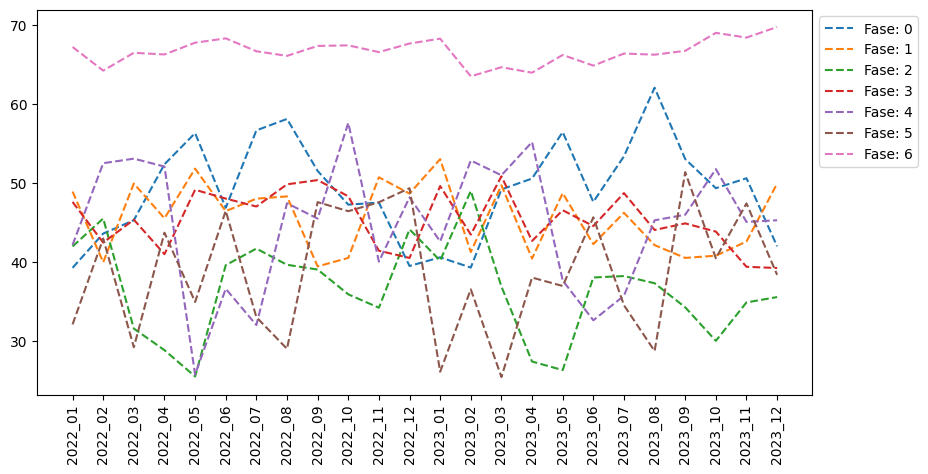

In [18]:
fase0=[]
fase1=[]
fase2=[]
fase3=[]
fase4=[]
fase5=[]
fase6=[]
for i in range(acc_fase_data.shape[0]):
    fase0.append(acc_fase_data['center'][i][0])
    fase1.append(acc_fase_data['center'][i][1])
    fase2.append(acc_fase_data['center'][i][2])
    fase3.append(acc_fase_data['center'][i][3])
    fase4.append(acc_fase_data['center'][i][4])
    fase5.append(acc_fase_data['center'][i][5])
    fase6.append(acc_fase_data['center'][i][6])
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, fase0, linestyle='--', label='Fase: 0', color='tab:blue')
plt.plot(x, fase1, linestyle='--', label='Fase: 1', color='tab:orange')
plt.plot(x, fase2, linestyle='--', label='Fase: 2', color='tab:green')
plt.plot(x, fase3, linestyle='--', label='Fase: 3', color='tab:red')
plt.plot(x, fase4, linestyle='--', label='Fase: 4', color='tab:purple')
plt.plot(x, fase5, linestyle='--', label='Fase: 5', color='tab:brown')
plt.plot(x, fase6, linestyle='--', label='Fase: 6', color='tab:pink')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

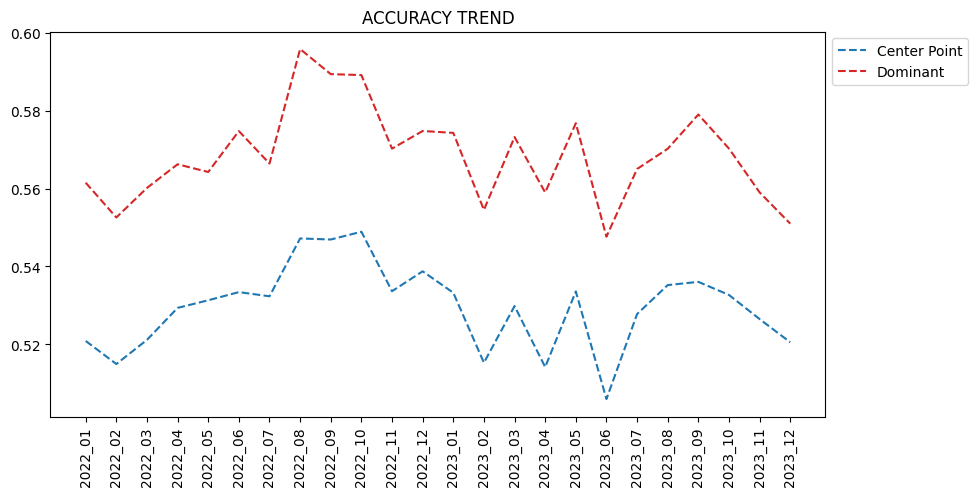

In [19]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][7])
    acc_dom.append(acc_fase_data['dom'][i][7])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

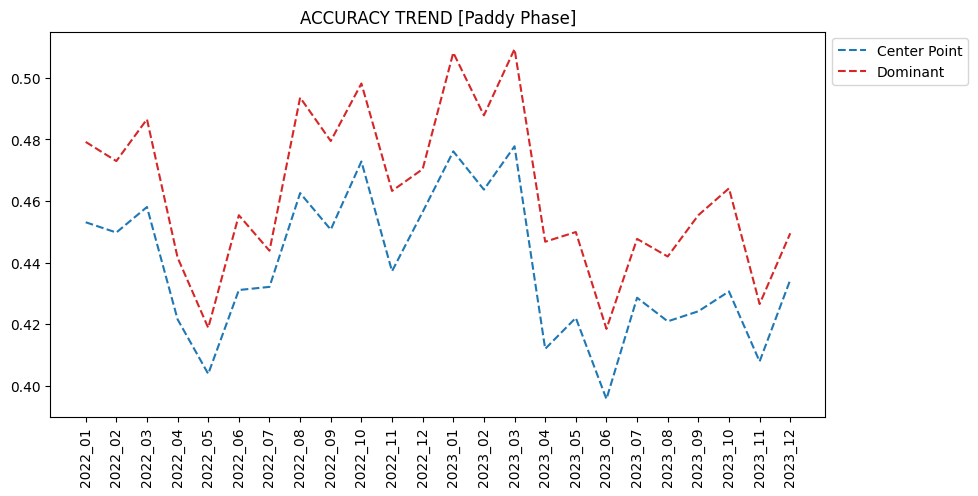

In [20]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][8])
    acc_dom.append(acc_fase_data['dom'][i][8])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_acc_paddy_tred.png', dpi=300, bbox_inches='tight')
plt.show()

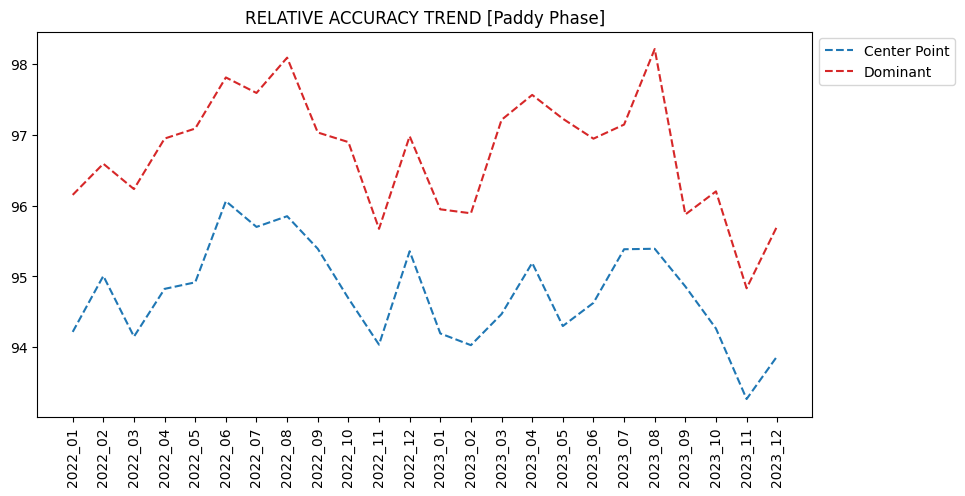

In [21]:

acc_cent=[]
acc_dom=[]
for i in range(acc_fase_data.shape[0]):
    acc_cent.append(acc_fase_data['center'][i][9])
    acc_dom.append(acc_fase_data['dom'][i][9])
    
x=acc_fase_data['index'].to_numpy()
plt.figure(figsize=(10, 5))
plt.plot(x, acc_cent, linestyle='--', label='Center Point', color='tab:blue')
plt.plot(x, acc_dom, linestyle='--', label='Dominant', color='tab:red')
plt.xticks(rotation=90)
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('RELATIVE ACCURACY TREND [Paddy Phase]')
plt.savefig(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_relacc_tred.png', dpi=300, bbox_inches='tight')
plt.show()

In [22]:
df_for_estimation['periode']=df_for_estimation.periode.apply(lambda y:y.replace('_',''))
df_for_estimation['id_segmen']=df_for_estimation.idsubsegment.apply(lambda y:y[:9])
df_for_estimation['subsegmen']=df_for_estimation.idsubsegment.apply(lambda y:y[9:])
df_for_estimation['tahun']=df_for_estimation.periode.apply(lambda y: y[:4])
df_for_estimation['bulan']=df_for_estimation.periode.apply(lambda y: y[4:])
df_for_estimation['fase_obs']=df_for_estimation.observation
df_for_estimation['fase_pred']=df_for_estimation.center_pred
df_for_estimation['fase_dom']=df_for_estimation.dom_pred
df_for_estimation.to_csv(f'/data/ksa/05_Modelling/metrics_results/{kdprov}_forestimation.csv',sep=';')